# Fifty One and Pytorch Installation

In [ ]:
!pip install fiftyone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 15.0 MB/s 
     |████████████████████████████████| 79.9 MB 1.2 MB/s 
     |████████████████████████████████| 132 kB 74.0 MB/s 
     |████████████████████████████████| 57 kB 5.9 MB/s 
     |████████████████████████████████| 133 kB 82.6 MB/s 
     |████████████████████████████████| 108 kB 56.5 MB/s 
     |████████████████████████████████| 63 kB 2.7 MB/s 
     |████████████████████████████████| 56 kB 5.1 MB/s 
     |████████████████████████████████| 37.8 MB 1.2 MB/s 
     |████████████████████████████████| 226 kB 76.1 MB/s 
     |████████████████████████████████| 49 kB 7.0 MB/s 
     |████████████████████████████████| 192 kB 79.8 MB/s 
     |████████████████████████████████| 564 kB 77.0 MB/s 
     |████████████████████████████████| 80 kB 10.2 MB/s 
     |████████████████████████████████| 202 kB 77.4 MB/s 
     |████████████████████████████████| 

In [ ]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz
import torch
import torchvision
from PIL import Image
from torchvision.transforms import functional
from fiftyone import ViewField

Migrating database to v0.18.0


INFO:fiftyone.migrations.runner:Migrating database to v0.18.0


# Load Dataset COCO 2017

In [ ]:
coco_dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    dataset_name="evaluate-detections-tutorial",
)
coco_dataset.persistent = True

INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/coco-2017/validation' if necessary


INFO:fiftyone.utils.coco:Downloading annotations to '/root/fiftyone/coco-2017/tmp-download/annotations_trainval2017.zip'


 100% |██████|    1.9Gb/1.9Gb [20.2s elapsed, 0s remaining, 113.3Mb/s]      


INFO:eta.core.utils: 100% |██████|    1.9Gb/1.9Gb [20.2s elapsed, 0s remaining, 113.3Mb/s]      


Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_val2017.json'


INFO:fiftyone.utils.coco:Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_val2017.json'


INFO:fiftyone.utils.coco:Downloading images to '/root/fiftyone/coco-2017/tmp-download/val2017.zip'


 100% |██████|    6.1Gb/6.1Gb [1.1m elapsed, 0s remaining, 103.3Mb/s]     


INFO:eta.core.utils: 100% |██████|    6.1Gb/6.1Gb [1.1m elapsed, 0s remaining, 103.3Mb/s]     


Extracting images to '/root/fiftyone/coco-2017/validation/data'


INFO:fiftyone.utils.coco:Extracting images to '/root/fiftyone/coco-2017/validation/data'


Writing annotations to '/root/fiftyone/coco-2017/validation/labels.json'


INFO:fiftyone.utils.coco:Writing annotations to '/root/fiftyone/coco-2017/validation/labels.json'


Dataset info written to '/root/fiftyone/coco-2017/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/coco-2017/info.json'


Loading 'coco-2017' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'coco-2017' split 'validation'


 100% |███████████████| 5000/5000 [39.4s elapsed, 0s remaining, 165.9 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 5000/5000 [39.4s elapsed, 0s remaining, 165.9 samples/s]      


Dataset 'evaluate-detections-tutorial' created


INFO:fiftyone.zoo.datasets:Dataset 'evaluate-detections-tutorial' created


In [ ]:
# Print some information about the dataset
print(coco_dataset)

Name:        evaluate-detections-tutorial
Media type:  image
Num samples: 5000
Persistent:  True
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [ ]:
# Print a ground truth detection
dataset_sample = coco_dataset.first()
print(dataset_sample.ground_truth.detections[0])

<Detection: {
    'id': '63a5e68f95b0224fcfb7a08b',
    'attributes': {},
    'tags': [],
    'label': 'potted plant',
    'bounding_box': [
        0.37028125,
        0.3345305164319249,
        0.038593749999999996,
        0.16314553990610328,
    ],
    'mask': None,
    'confidence': None,
    'index': None,
    'supercategory': 'furniture',
    'iscrowd': 0,
}>


In [ ]:
session = fo.launch_app(coco_dataset)

# Load Model

In [ ]:
# Run the model on GPU if it is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load a pre-trained Faster R-CNN model
rcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
rcnn_model.to(device)
rcnn_model.eval()

print("Models are ready")

Models are ready


# Prediction

In [ ]:
rcnn_pred = coco_dataset.take(5000)

In [ ]:
# Get class list
classes = coco_dataset.default_classes

In [ ]:
# Add predictions to samples
with fo.ProgressBar() as pb:
    for rcnn_sample in pb(rcnn_pred):
        # Load image
        image = Image.open(rcnn_sample.filepath)
        image = functional.to_tensor(image).to(device)
        c, h, w = image.shape
        
        # Perform inference
        preds = rcnn_model([image])[0]
        labels = preds["labels"].cpu().detach().numpy()
        scores = preds["scores"].cpu().detach().numpy()
        boxes = preds["boxes"].cpu().detach().numpy()
        
        # Convert detections to FiftyOne format
        detections = []
        for label, score, box in zip(labels, scores, boxes):
            # Convert to [top-left-x, top-left-y, width, height]
            # in relative coordinates in [0, 1] x [0, 1]
            x1, y1, x2, y2 = box
            rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]

            detections.append(
                fo.Detection(
                    label=classes[label],
                    bounding_box=rel_box,
                    confidence=score
                )
            )
        
        # Save predictions to dataset
        rcnn_sample["faster_rcnn"] = fo.Detections(detections=detections)
        rcnn_sample.save()

 100% |███████████████| 5000/5000 [12.1m elapsed, 0s remaining, 6.6 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 5000/5000 [12.1m elapsed, 0s remaining, 6.6 samples/s]      


# Confidence Threshold

In [ ]:
# Only contains detections with confidence >= 0.5
conf_rcnn = rcnn_pred.filter_labels("faster_rcnn", ViewField("confidence") > 0.5, only_matches=False)

In [ ]:
print(conf_rcnn)

Dataset:     evaluate-detections-tutorial
Media type:  image
Num samples: 5000
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    faster_rcnn:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
View stages:
    1. Take(size=5000, seed=None)
    2. FilterLabels(field='faster_rcnn', filter={'$gt': ['$$this.confidence', 0.5]}, only_matches=False, trajectories=False)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


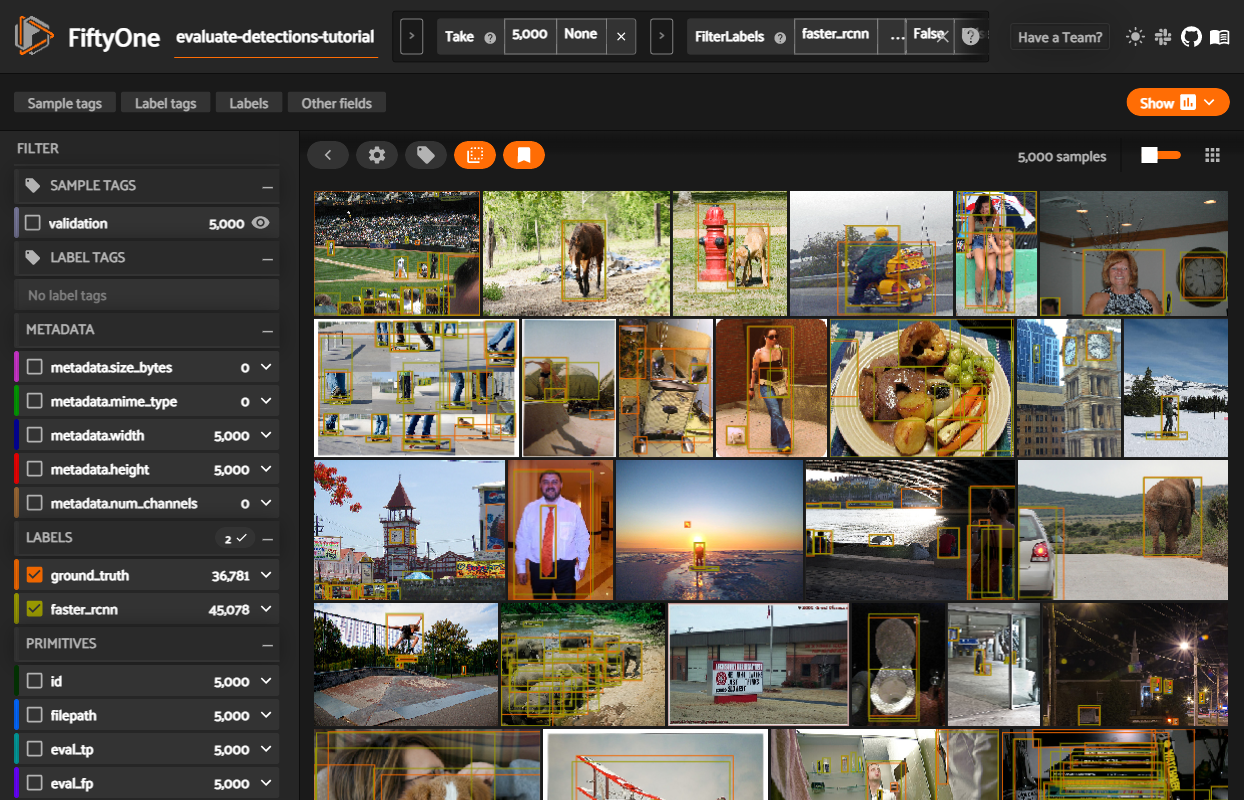

<IPython.core.display.Javascript object>

In [ ]:
session.view = conf_rcnn

# fasterrcnn_resnet50_fpn Evaluation

In [ ]:
# Evaluate the predictions in the `faster_rcnn` field of our `high_conf_view`
# with respect to the objects in the `ground_truth` field
rcnn_results = conf_rcnn.evaluate_detections(
    "faster_rcnn",
    gt_field="ground_truth",
    eval_key="eval",
    compute_mAP=True,
)

Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████| 5000/5000 [3.7m elapsed, 0s remaining, 16.8 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 5000/5000 [3.7m elapsed, 0s remaining, 16.8 samples/s]      


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████| 5000/5000 [1.7m elapsed, 0s remaining, 49.1 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 5000/5000 [1.7m elapsed, 0s remaining, 49.1 samples/s]      


In [ ]:
ious_rcnn_sum = 0
for i in range(len(rcnn_results.ious)):
  if rcnn_results.ious[i] != None:
    ious_rcnn_sum += rcnn_results.ious[i]
ious_rcnn_avg = ious_rcnn_sum/len(rcnn_results.ious)
print(ious_rcnn_avg)

0.4067776204940436


In [ ]:
# Get the 10 most common classes in the dataset
rcnn_counts = coco_dataset.count_values("ground_truth.detections.label")
rcnn_classes_sorted = sorted(rcnn_counts, key=rcnn_counts.get, reverse=True)

# Print a classification report for the top-10 classes
rcnn_results.print_report(classes = rcnn_classes_sorted)

                precision    recall  f1-score   support

        person       0.76      0.84      0.80     12874
           car       0.62      0.73      0.67      2086
         chair       0.49      0.49      0.49      1861
          book       0.59      0.63      0.61      1832
        bottle       0.58      0.65      0.61      1114
           cup       0.54      0.61      0.57       912
  dining table       0.38      0.54      0.44       697
 traffic light       0.53      0.59      0.56       644
          bowl       0.48      0.63      0.55       635
       handbag       0.35      0.31      0.33       540
          bird       0.74      0.68      0.71       627
          boat       0.51      0.62      0.56       463
         truck       0.50      0.59      0.54       415
         bench       0.39      0.38      0.38       414
      umbrella       0.57      0.63      0.60       435
           cow       0.70      0.76      0.73       414
        banana       0.53      0.58      0.56  

In [ ]:
print(rcnn_results.mAP())

0.34428277807769436


In [ ]:
plot = rcnn_results.plot_pr_curves(classes=[
 'person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
])
plot.show()

In [ ]:
rcnn_sample = conf_rcnn.first()
print(rcnn_sample.faster_rcnn.detections[0])

<Detection: {
    'id': '63a641899e98a88f75158be2',
    'attributes': {},
    'tags': [],
    'label': 'person',
    'bounding_box': [
        0.4831292152404785,
        0.5275445620218913,
        0.08164582252502442,
        0.17317399978637696,
    ],
    'mask': None,
    'confidence': 0.9993188381195068,
    'index': None,
    'eval_iou': 0.9290521114472019,
    'eval_id': '63a6411e9e98a88f7514fcf5',
    'eval': 'tp',
}>


In [ ]:
rcnn_eval_patches = coco_dataset.to_evaluation_patches("eval")
print(rcnn_eval_patches)

Dataset:     evaluate-detections-tutorial
Media type:  image
Num patches: 182096
Patch fields:
    id:           fiftyone.core.fields.ObjectIdField
    sample_id:    fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    faster_rcnn:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    crowd:        fiftyone.core.fields.BooleanField
    type:         fiftyone.core.fields.StringField
    iou:          fiftyone.core.fields.FloatField
View stages:
    1. ToEvaluationPatches(eval_key='eval', config=None)


In [ ]:
session.view = rcnn_eval_patches